In [93]:
import os
import glob
import pandas as pd
import datetime
import numpy as np


infiles = glob.glob('/home/pm/Documents_sync/PhD/StHelens/gnss_cleaned/panga_raw/*.rad')
coord_file = '/home/pm/Documents_sync/PhD/StHelens/gnss_data/{station}.cwu.final_nam14.pos'

positions = {}


# write a function that does the inverse of this
def date_from_year_fraction(year_fraction):
    year = int(year_fraction)
    start = datetime.date(year, 1, 1).toordinal()
    year_length = datetime.date(year+1, 1, 1).toordinal() - start
    return datetime.date.fromordinal(
        start + int(year_length * (year_fraction % 1)))

for infile in infiles:
    # retrieve station name
    station = os.path.basename(infile).split('.')[0]
    # retrieve GPS position and time dependent height
    # create new date column
    df = pd.read_csv(
        infile, delim_whitespace=True,
        skipinitialspace=True, comment='#', names=('t', 'offset', 'sigma'))
    # apply the correction for jumps provided in the same file
    # open with text editor and find line with jumps
    
    print(df)
    # convert field t to datetimes and add it as new column
    df['t'] = df['t'].apply(date_from_year_fraction)
    df2 = pd.read_csv(
        coord_file.format(station=station), delim_whitespace=True,
        skipinitialspace=True, skiprows=36, usecols=(12, 13))
    df['lat'] = df2['NLat'][0]
    df['lon'] = df2['Elong'][0]
    # set offset to zero where t is closest to 2007-01-01
    if min(abs(df['t'] - datetime.date(2007, 7, 1))) > datetime.timedelta(days=30):
        print(station, ' is not available')
        continue
    argmin = np.argmin(abs(df['t'] - datetime.date(2007, 7, 1)))
    df['offset'] = df['offset'] - df['offset'][argmin]
    # try:
    #     df['offset'] = df['offset'] - df['offset'][df['t'] == datetime.date(2007, 10, 1)].values[0]
    # except IndexError:
    #     print(station, ' is not available')
    #     continue
    positions[station] = df

ParserError: Error tokenizing data. C error: Expected 5 fields in line 9, saw 9


In [203]:
import re

def find_constants(file_path):
    # Open the file and read its contents
    with open(file_path, 'r') as file:
        file_content = file.read()
        # Find the line containing the function definition
        function_line_match = re.search(r'# jumps\(t\)=(.*?)(?=\n|$)', file_content, re.DOTALL)
        if function_line_match:
            # Extract the entire line with the jumps equation
            function_line = function_line_match.group(1).strip().replace(' ', '')

            # Extract all decimal year values from the function line
            decimal_year_values = [float(match) for match in re.findall(r'(\d+\.\d+)', function_line)]
            

            # Extract constants P X from the file starting from P5
            constant_matches = re.finditer(r'# P (\d+) =\s+([-+]?[0-9]*\.?[0-9]+(?:[eE][-+]?[0-9]+)?)', file_content)
            constants = {f'P{match.group(1)}': float(match.group(2)) for match in constant_matches if int(match.group(1)) >= 5}
            # Create a Python function from the extracted information

            # Create a Python function from the extracted information
            for decimal_year_value in decimal_year_values:
                function_line = function_line.replace(f'(t-{decimal_year_value})', '')
            function_line = function_line.replace('heav', 'np.heaviside(t - {}, 0)')
            for constant in constants:
                function_line = function_line.replace(constant, f'constants["{constant}"]')

            # Adjust the format placeholders for decimal year values
            function_line = function_line.format(*decimal_year_values)

            function_code = f"def offset_correction(t, constants): return {function_line}"
            print(function_line)
            # Create a Python function from the extracted information
            local_vars = locals()
            exec(function_code, globals(), local_vars)
            offset_correction = local_vars['offset_correction']

            return offset_correction, constants

        else:
            print("Function line not found in the file.")
            return None, None

# Example usage
file_path = '/home/pm/Documents_sync/PhD/StHelens/gnss_cleaned/panga_raw/JRO1.rad'  # Replace with the actual file path

offset_correction_function, constants_dict = find_constants(file_path)

if offset_correction_function and constants_dict:
    print("Offset correction function:")
    print(offset_correction_function)

    print("\nConstants:")
    print(constants_dict)

# Call the function with constants
result = offset_correction_function(2007.825, constants=constants_dict)
print("Result:", result)


+constants["P5"]*np.heaviside(t - 1998.5161, 0)+constants["P6"]*np.heaviside(t - 2002.5379, 0)+constants["P7"]*np.heaviside(t - 2008.1533, 0)+constants["P8"]*np.heaviside(t - 2012.0082, 0)
Offset correction function:
<function offset_correction at 0x7f77f62603a0>

Constants:
{'P5': 4.1338, 'P6': -11.91821, 'P7': -0.30405, 'P8': 12.06681}
Result: -7.78441


In [205]:
offset_correction_function(30e3, constants_dict)

3.9783500000000007

In [160]:
print(constants_dict)

{'P5': 4.1338, 'P6': -11.91821, 'P7': -0.30405, 'P8': 12.06681}


In [176]:
offset_correction_function(2007.825, constants_dict)

TypeError: offset_correction() takes 1 positional argument but 2 were given

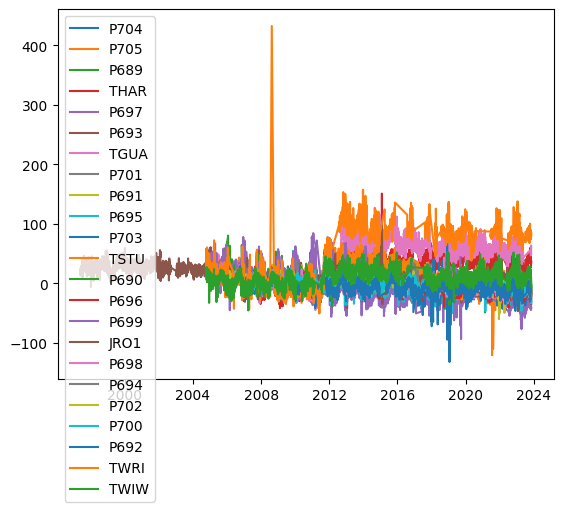

In [86]:
# plot this on a cartesian grid
import matplotlib.pyplot as plt
import numpy as np

# first simply in 1D
for station, df in positions.items():
    plt.plot(df['t'], positions[station]['offset'], label=station)
plt.legend()
# plt.ylim(-0.1, 0.1)

In [87]:
# load dv time-series
import glob
import os

import numpy as np
from matplotlib import pyplot as plt
from obspy import UTCDateTime


corr_len = 3
std_model = 0.002
dv = {}
for freq0, std_model in zip([0.25, 0.5, 1.0], [0.006, 0.002, 0.004]):
    infile = glob.glob(
        f'/home/pm/Documents_sync/PhD/StHelens/spatial/new_gap_handling_ddt_crosssingle_dvfilt_allcc_cl{corr_len}_std{std_model}_largemap/{freq0}-{freq0*2}/dvdt_3D.npz')[0]

    loaded = np.load(infile)

    x = loaded['xaxis']
    y = loaded['yaxis']
    t = loaded['taxis']
    dvdt = loaded['dv']

    start = np.argmin(abs(t - UTCDateTime('2007-06-01').timestamp))
    t = t[start:]
    dv[freq0] = -100*np.nancumsum(dvdt[:, :, start:], axis=-1)
datetimes = [UTCDateTime(tt).datetime for tt in t]



In [88]:
from obspy.signal.filter import highpass
from scipy.signal import detrend
# Filter dv signals
dv_hpf = {}
for freq0 in [0.25, 0.5, 1.0]:
    dv_1d = detrend(dv[freq0])
    df = 1/(datetimes[1]-datetimes[0]).total_seconds()
    filtfreq = 1/(2*365.25*24*60*60)
    dv_hpf[freq0] = highpass(dv_1d, filtfreq, df, corners=4, zerophase=True)

In [89]:
from obspy.geodetics import degrees2kilometers, locations2degrees
import numpy as np

# extents of the dv/v grid
lat = [46.05, 46.36]
lon = [-122.45, -122.03]
res = 1


for station, df in positions.items():
    # compute cartesian coordinates of each station
    df['x'] = -degrees2kilometers(locations2degrees(lat[0], 0, lat[0], df['lon'][0]))
    df['y'] = degrees2kilometers(locations2degrees(0, lon[0], df['lat'][0], lon[0]))
    if np.min(np.abs(df['x'][0] - x)) > res or np.min(np.abs(df['y'][0] - y)) > res:
        print(f'Skipping {station}')
        continue
    

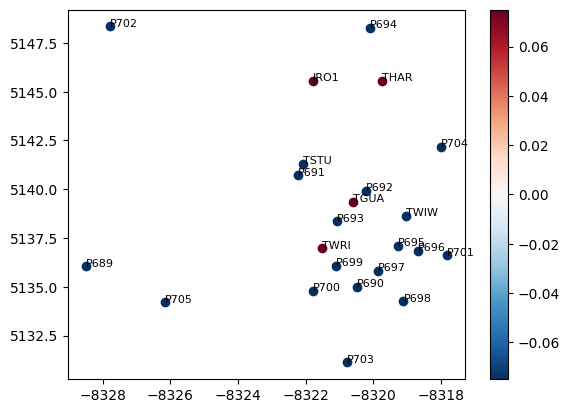

In [91]:
# create a scatter plot of the stations
# with the colour representing the height change
for station, df in positions.items():
    plt.scatter(df['x'].values[0], df['y'].values[0], c=df['offset'].values[-1], vmin=-0.075, vmax=0.075, cmap='RdBu_r')
    # plot the name of the station right next to the dot
    plt.text(df['x'].values[0], df['y'].values[0], station, fontsize=8)
plt.colorbar()

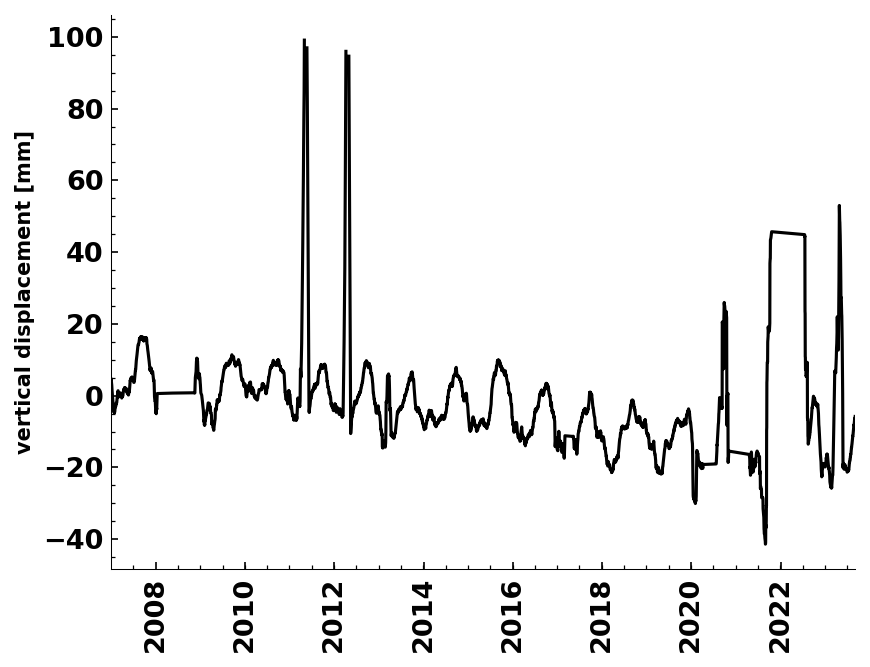

In [59]:
from seismic.plot.plot_utils import set_mpl_params
import datetime
set_mpl_params()
# plot station P705
station = 'P705'
plt.figure()
plt.plot(positions[station]['date'], positions[station]['dU_smoothed']*1e3, 'k', label=station)
plt.ylabel('vertical displacement [mm]')
# x-axis ticklabel rotation
plt.xticks(rotation=90)
plt.xlim(datetime.datetime(2007, 1, 1), datetime.datetime(2023, 9, 1))
# station = 'P691'
# plt.plot(positions[station]['date'], positions[station]['dU']*1e3, 'k', label=station)
# plt.ylabel('vertical displacement [mm]')
# # x-axis ticklabel rotation
# plt.xticks(rotation=90)
# turn top and right axes off
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
# turn off ticks where there is no spine
plt.gca().xaxis.set_ticks_position('bottom')
plt.gca().yaxis.set_ticks_position('left')


plt.savefig('/home/pm/Documents_sync/PhD/conferences/AGU23/poster/P705.png', dpi=300, transparent=True, bbox_inches='tight')

## 1D comparison dv/v and GPS motion

/tmp/ipykernel_443132/1398795182.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


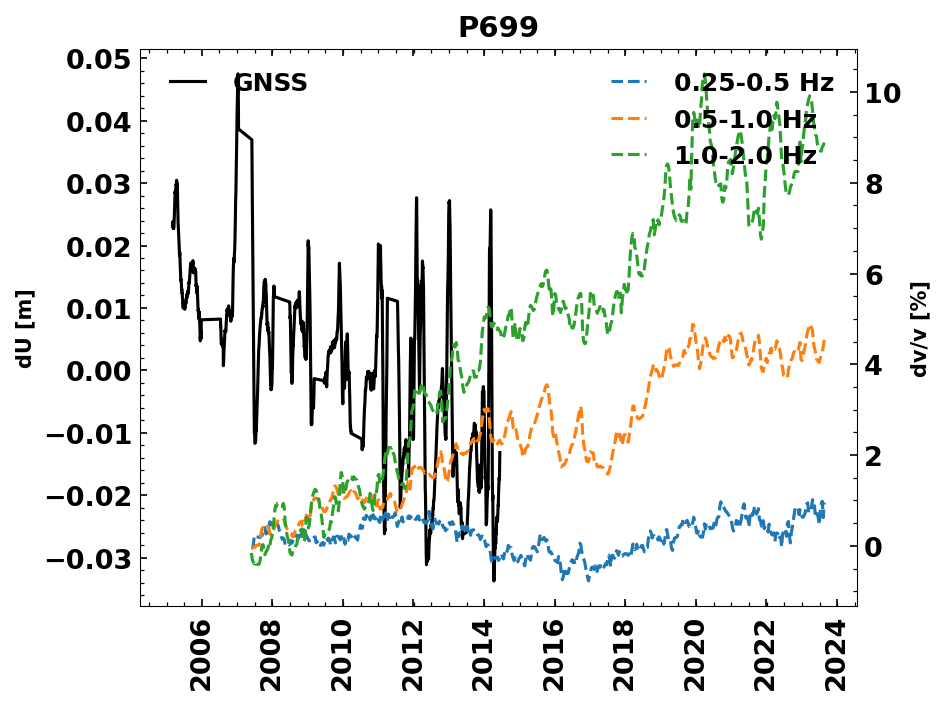

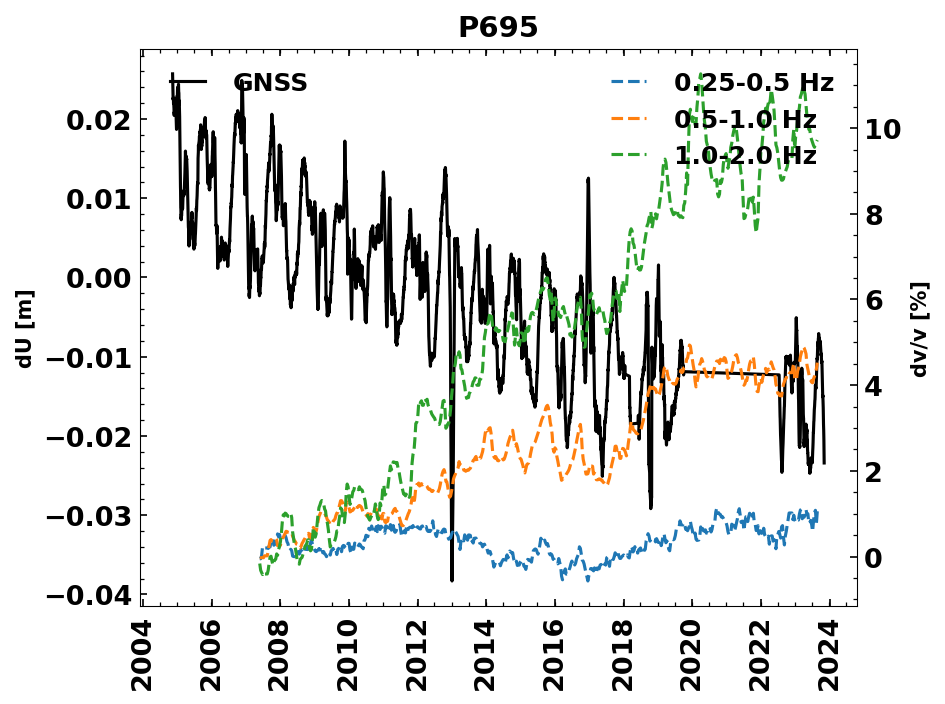

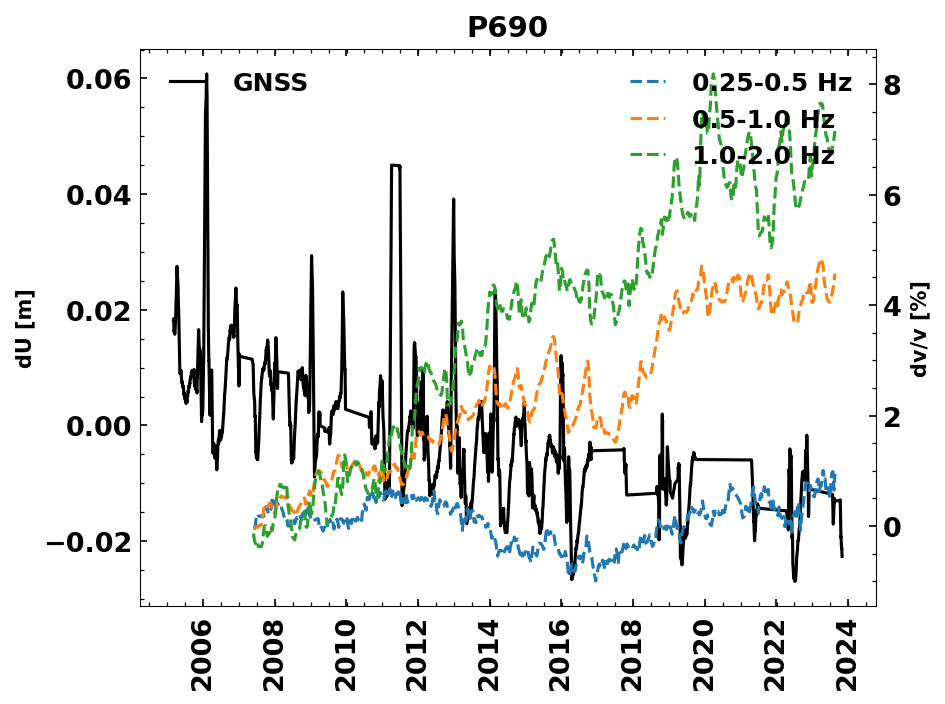

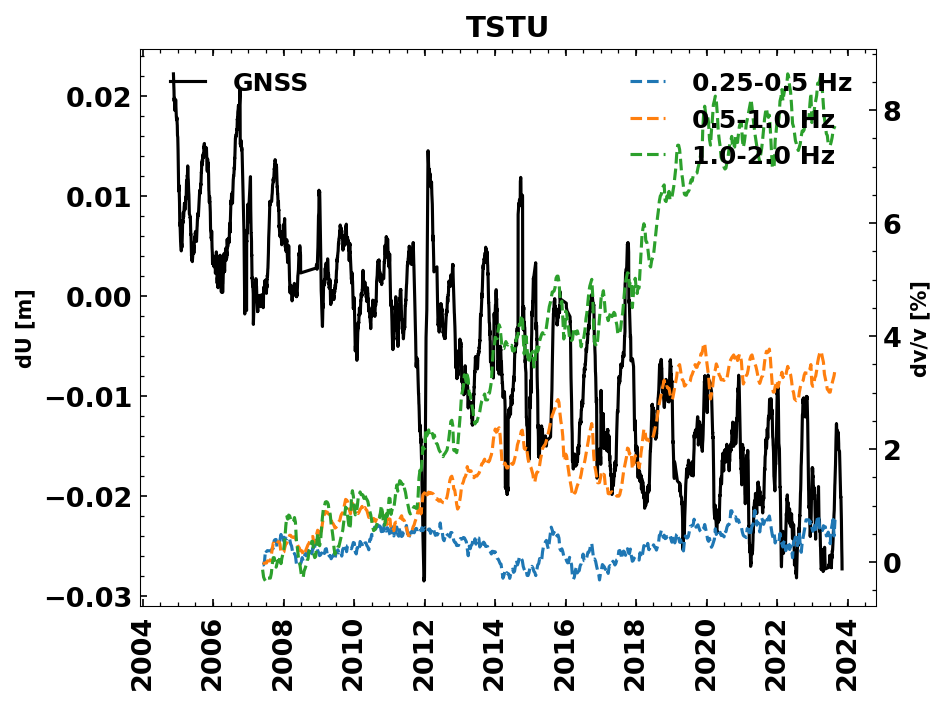

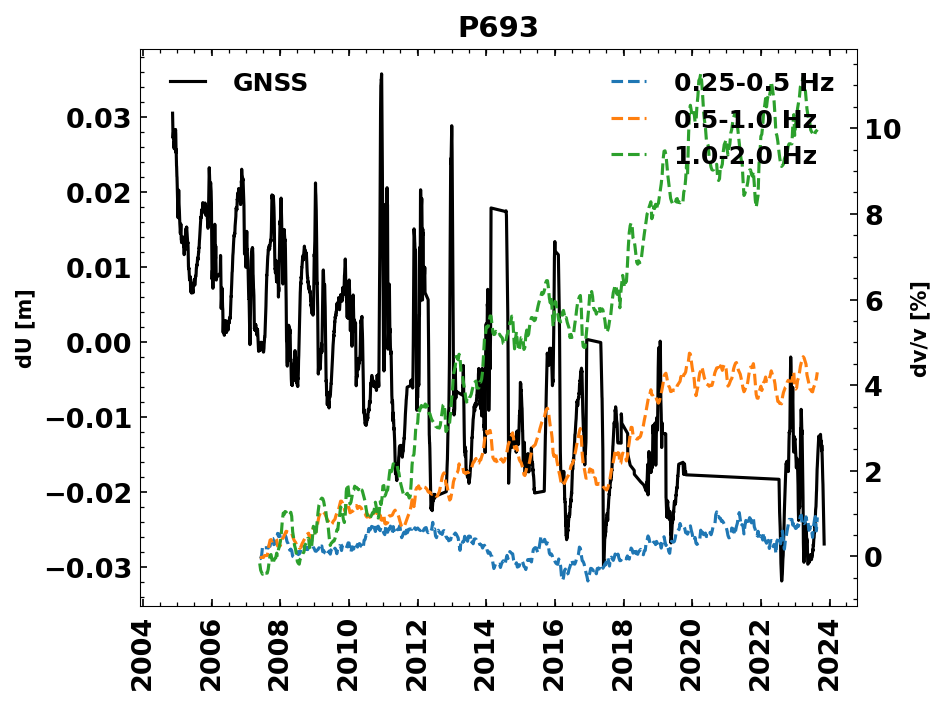

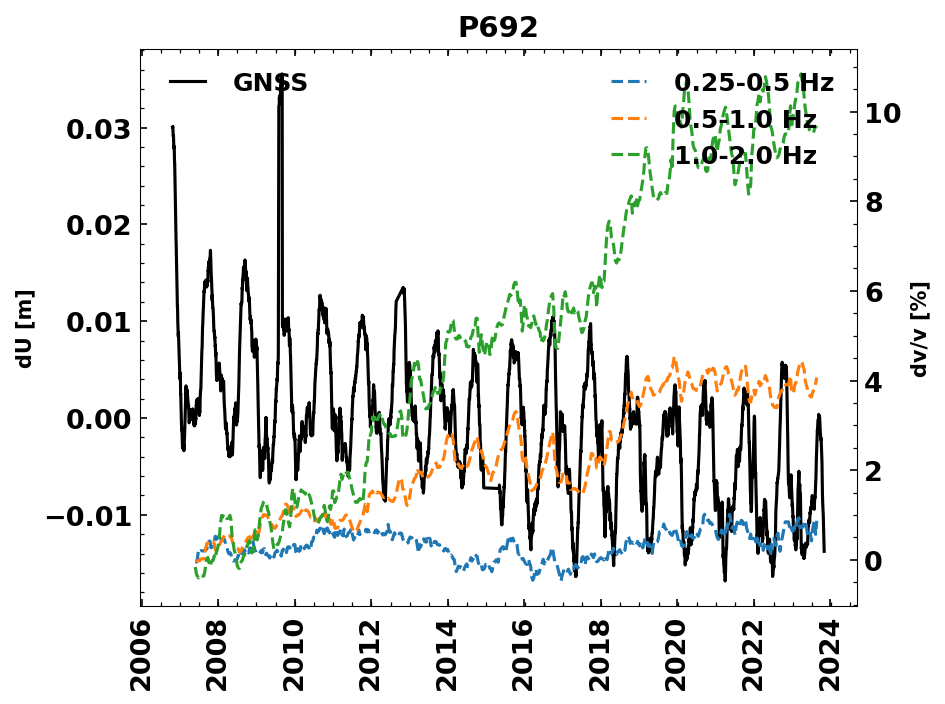

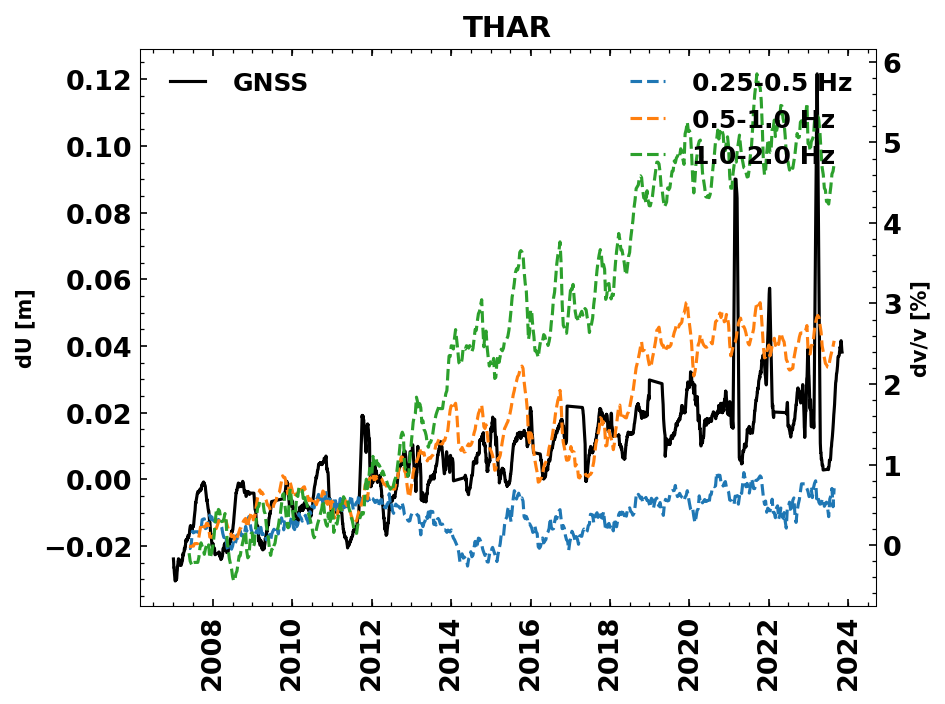

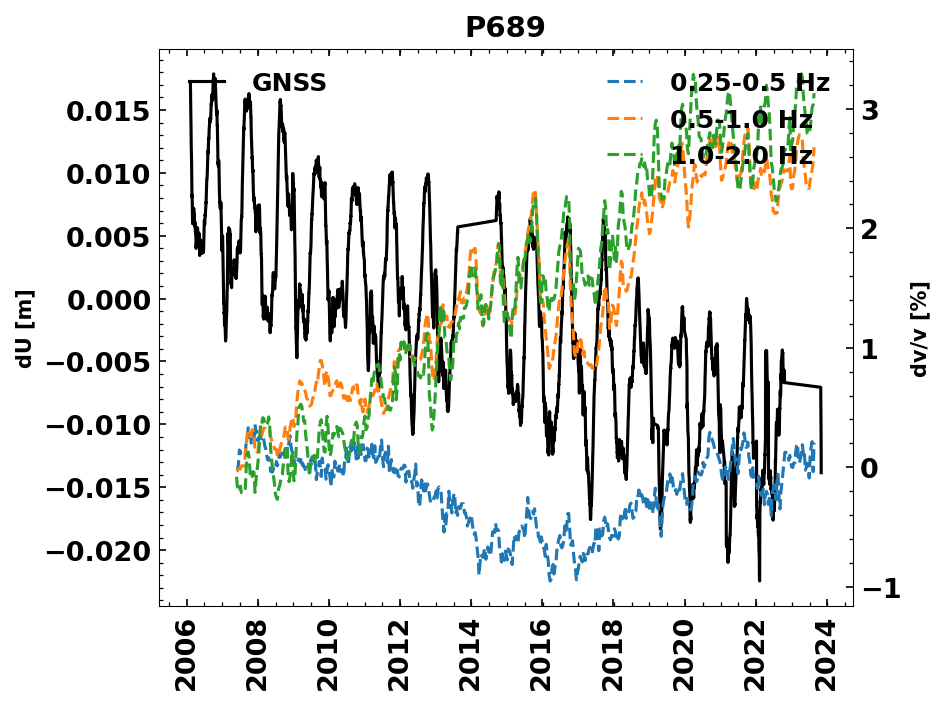

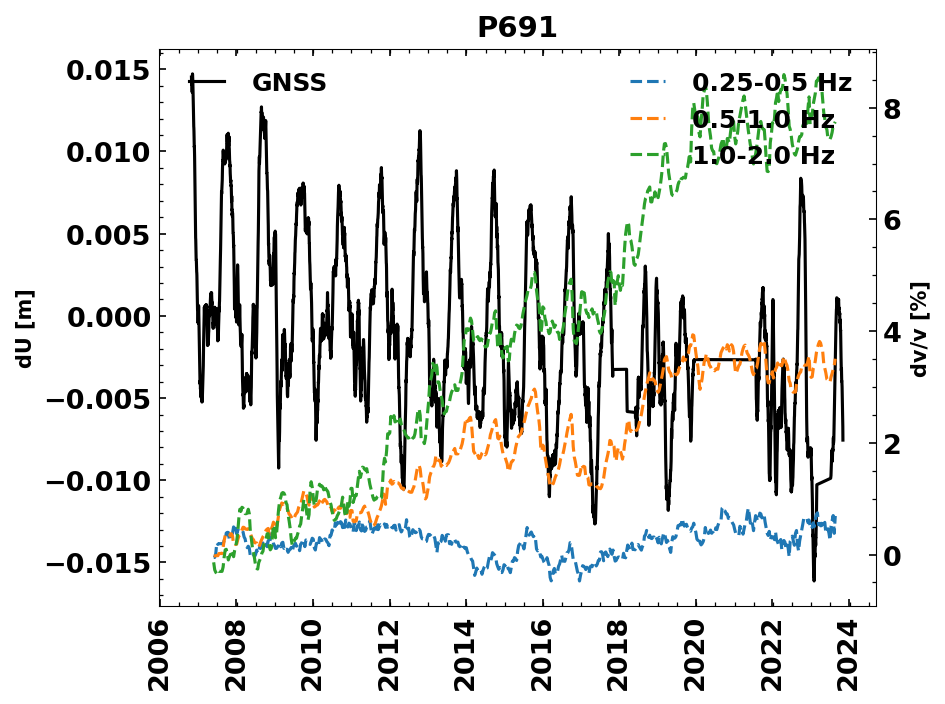

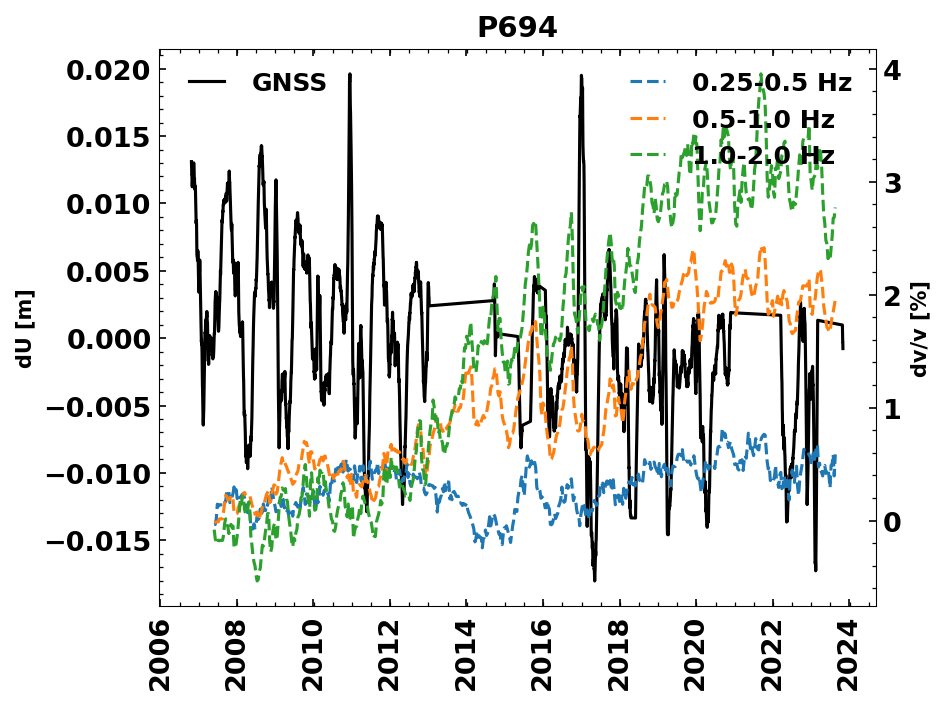

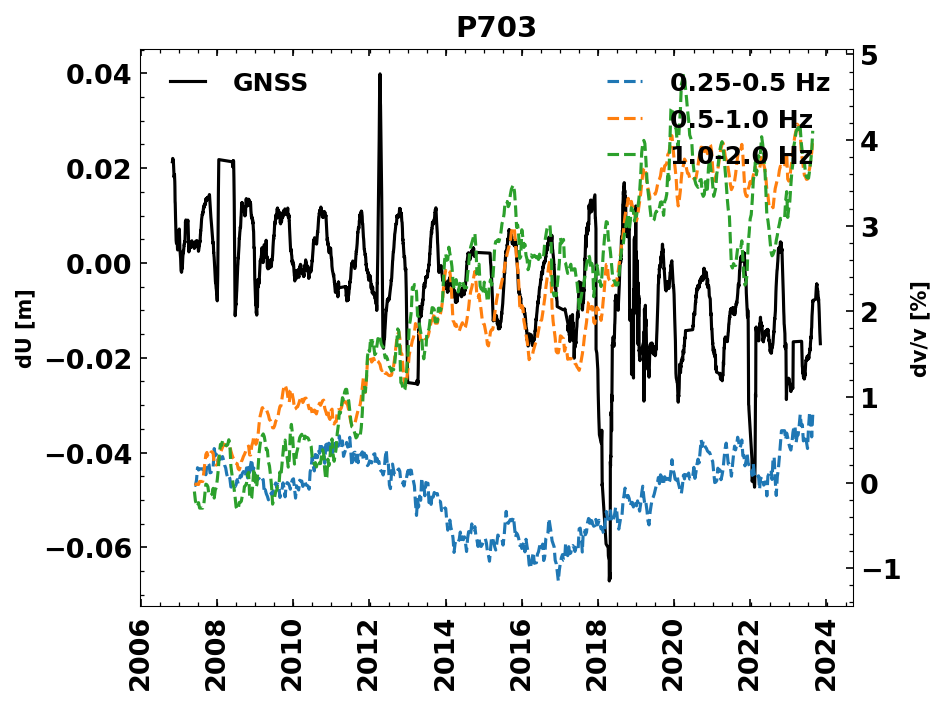

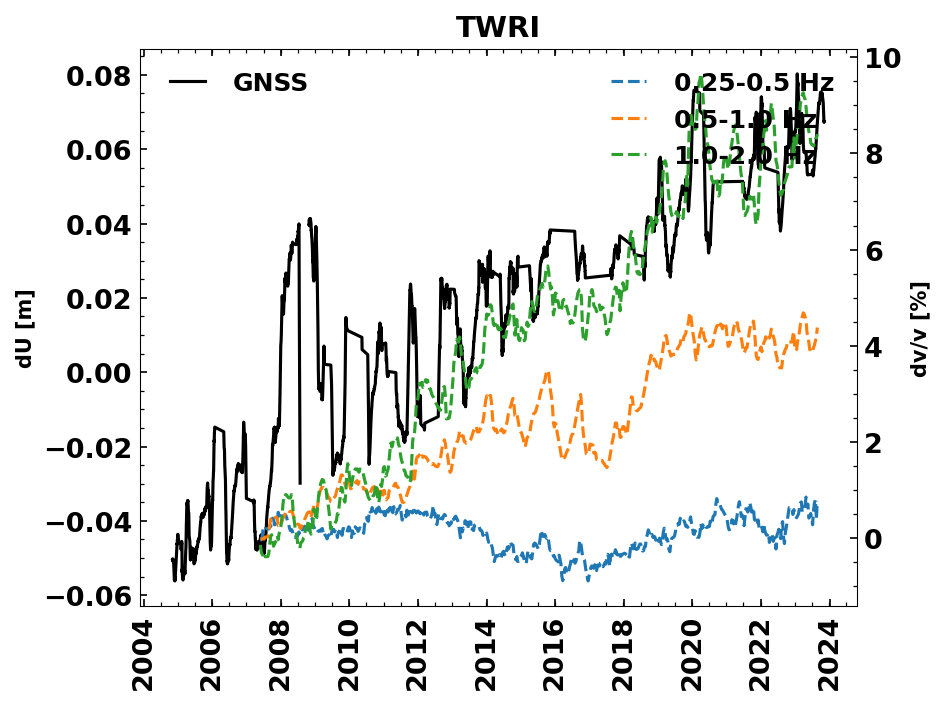

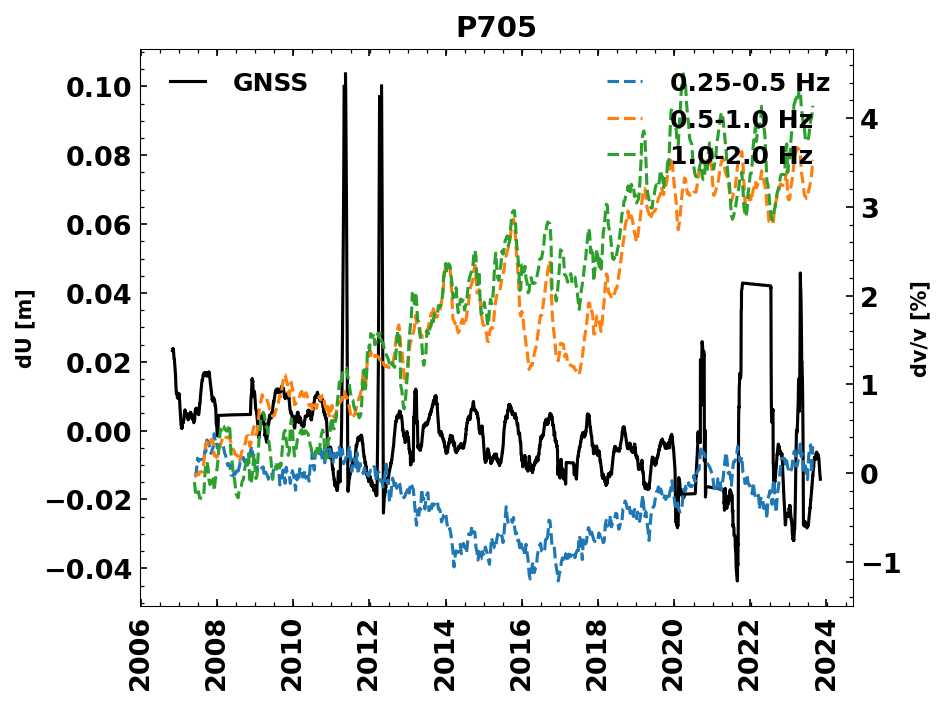

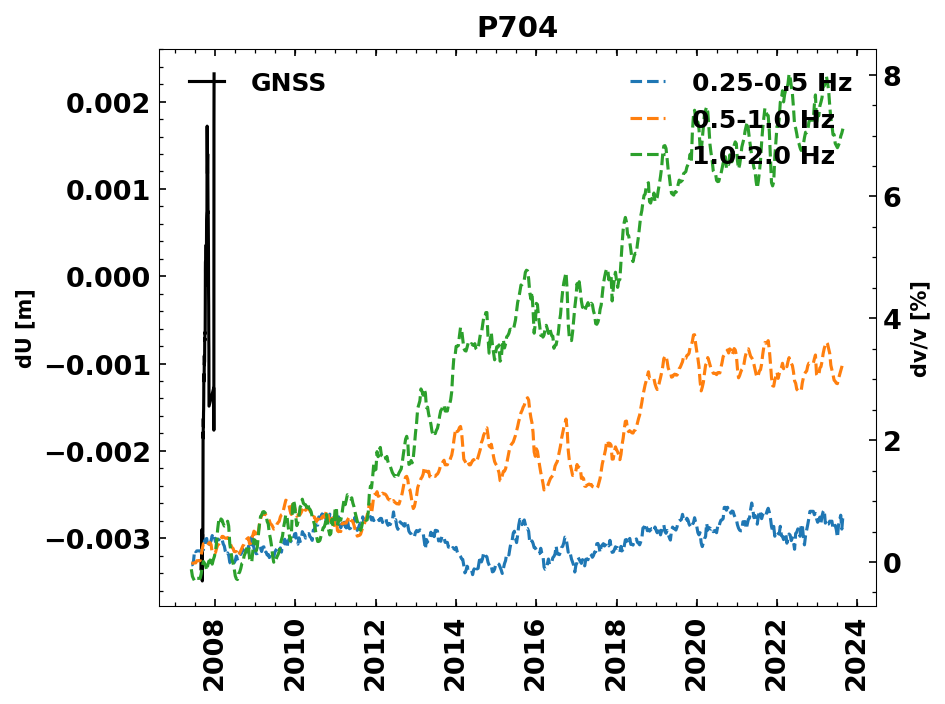

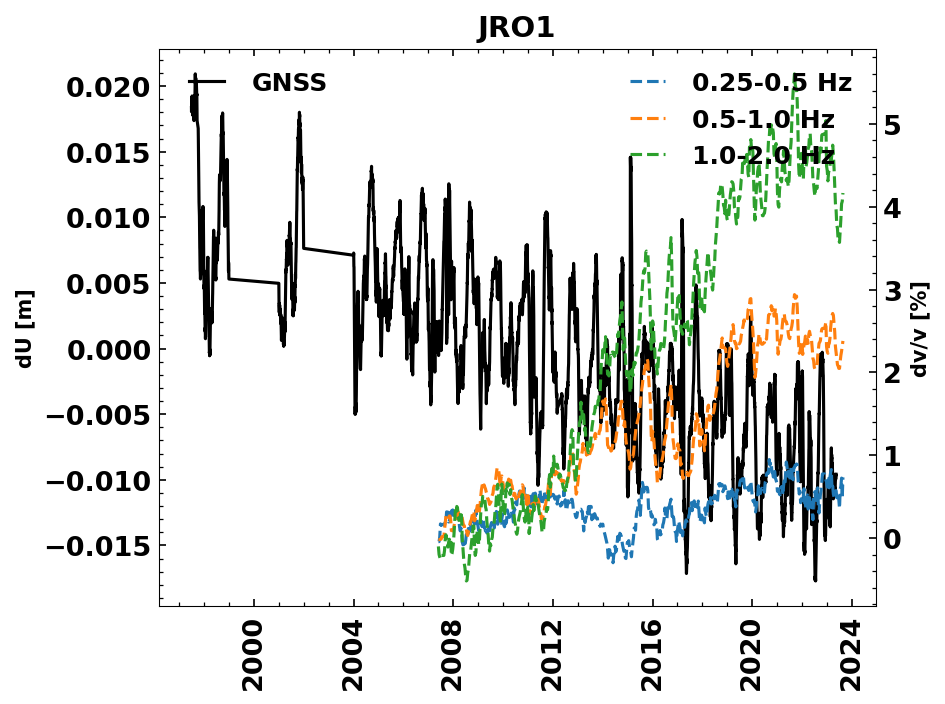

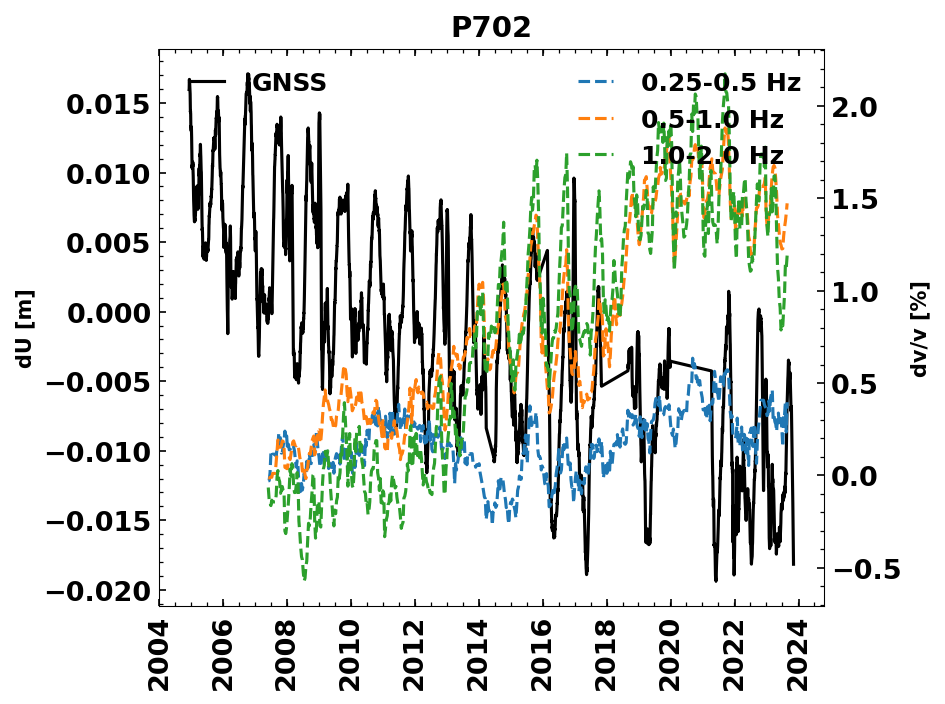

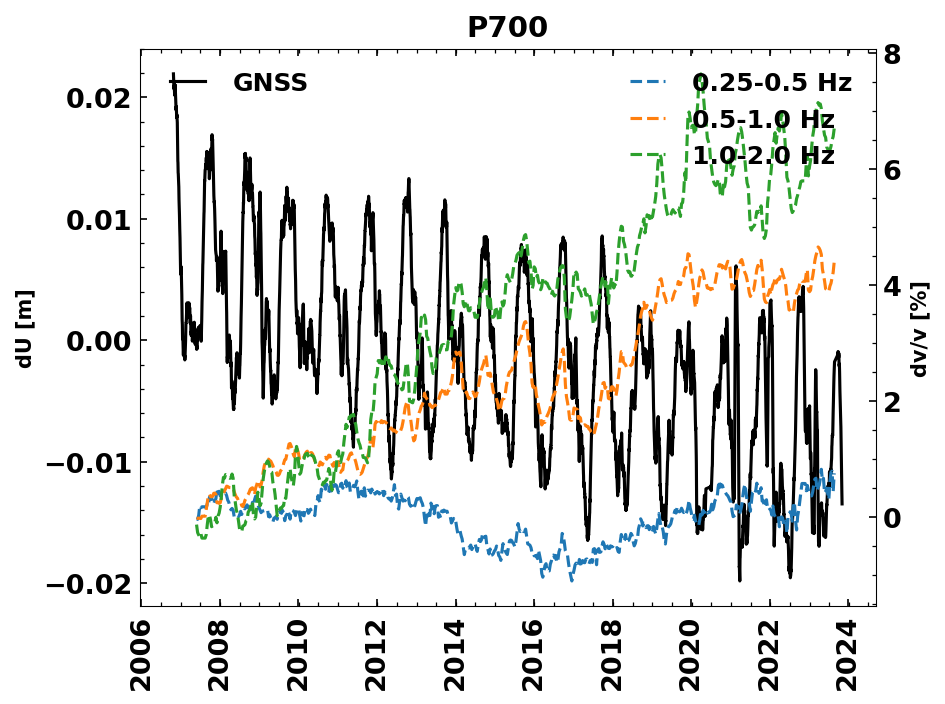

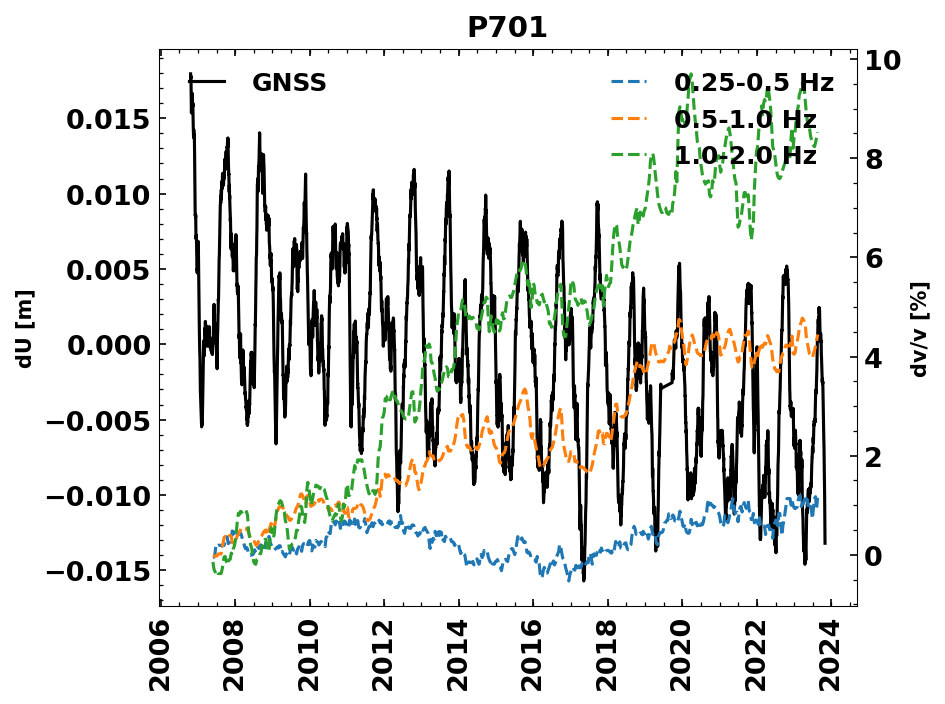

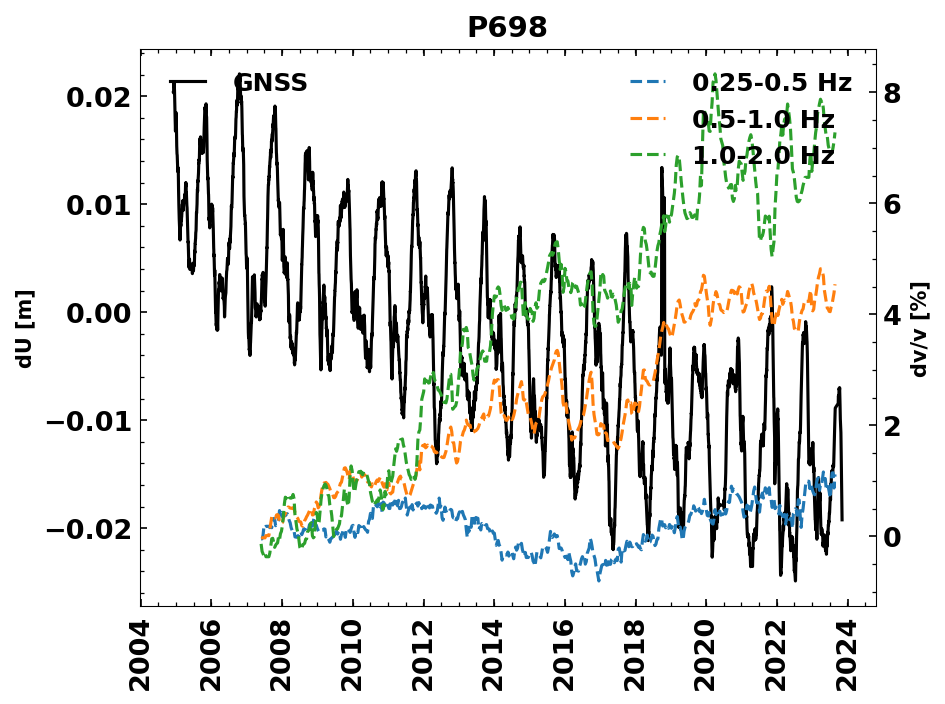

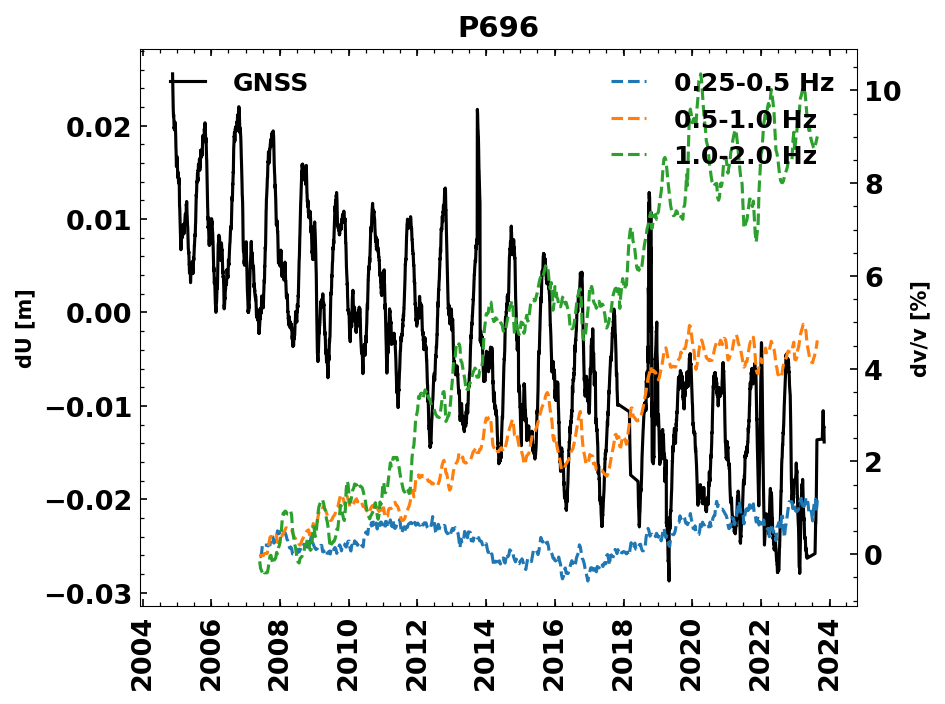

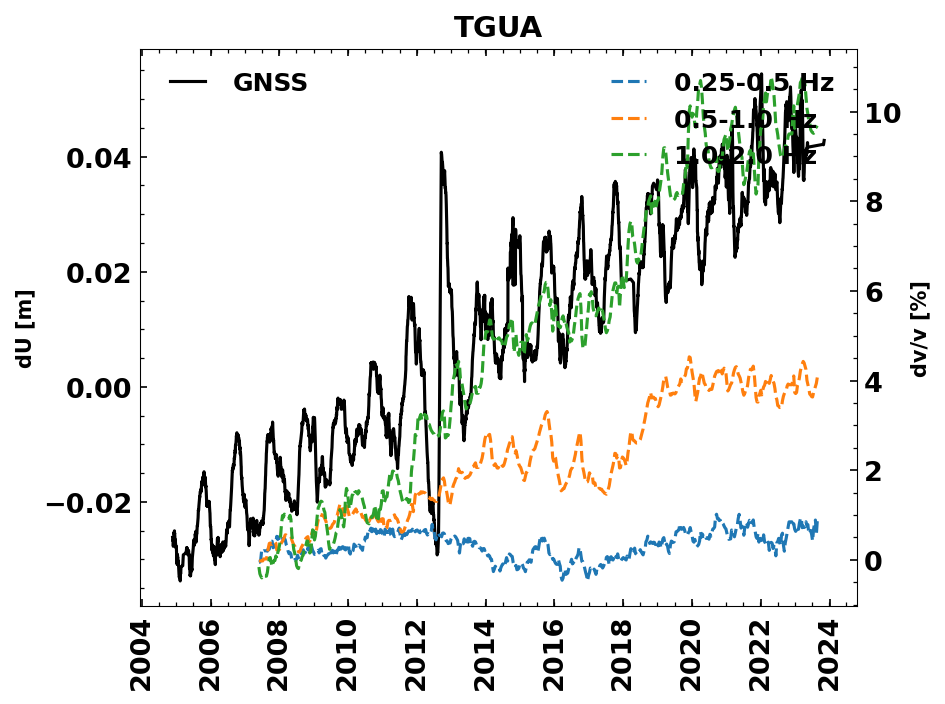

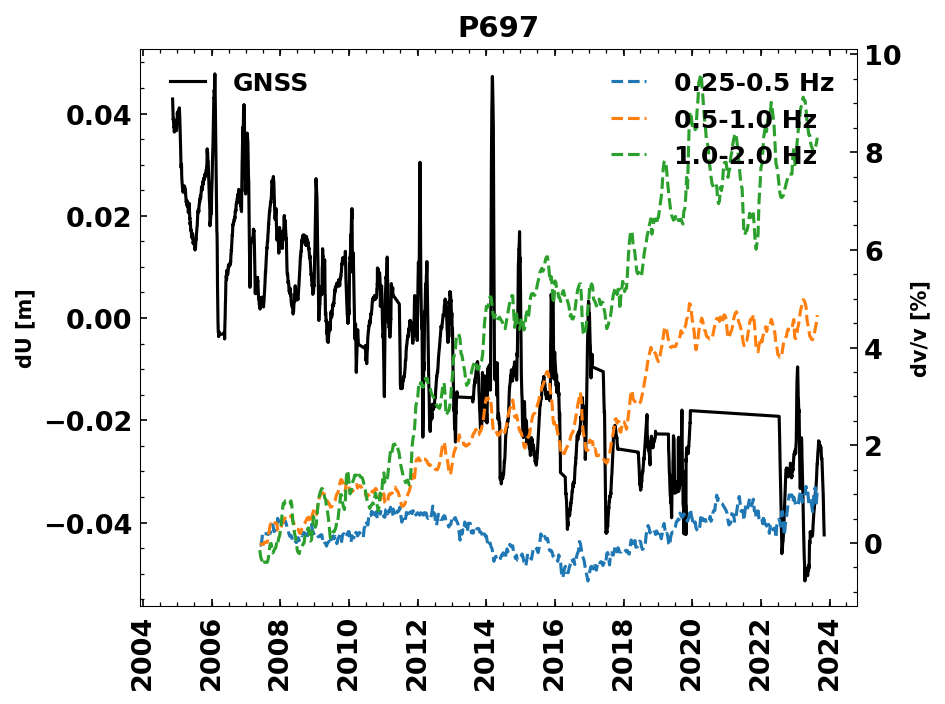

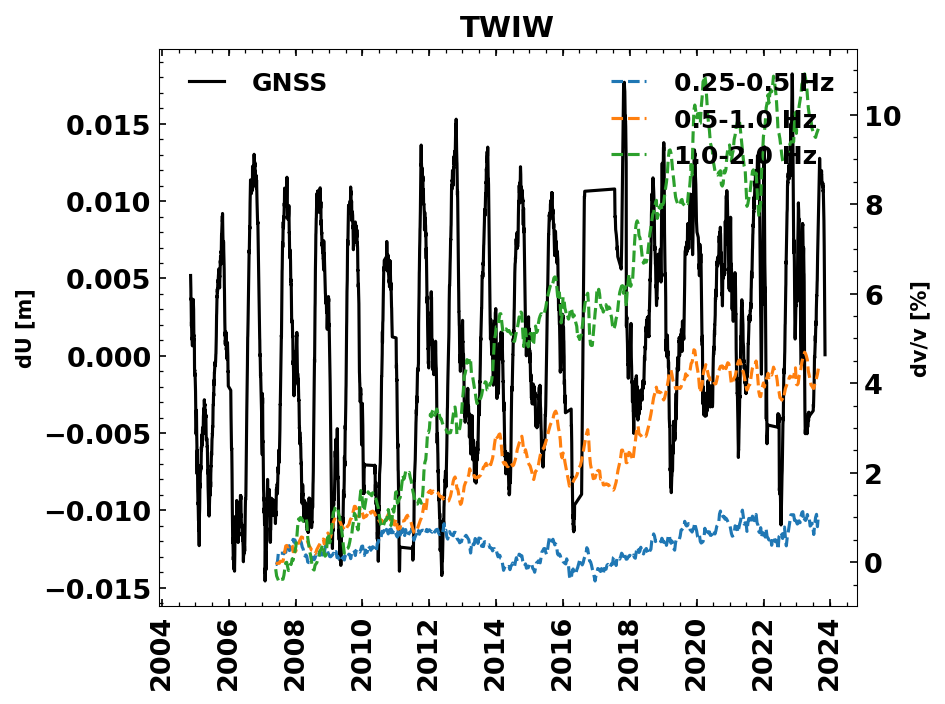

In [52]:
from seismic.plot.plot_utils import set_mpl_params

set_mpl_params()

# find closest grid point of each station and plot against dv/v of this grid point

for station, df in positions.items():
    plt.figure()
    # find closest grid point
    plt.plot(df['date'], df['dU_smoothed'], label='GNSS', color='k')
    plt.ylabel('dU [m]')
    plt.legend()
    # rotate xticklabels by 90 deg
    plt.xticks(rotation=90)
    plt.twinx()
    xind = np.argmin(np.abs(df['x'][0] - x))
    yind = np.argmin(np.abs(df['y'][0] - y))
    # plot dv/v time series
    for freq0 in [0.25, 0.5, 1.0]:
        plt.plot(datetimes, dv[freq0][yind, xind, :], label=f'{freq0}-{freq0*2} Hz', linestyle='--')
    # plot this legend in top right
    plt.legend(loc='upper right')
    plt.ylabel('dv/v [%]')
    plt.title(station)
    
    plt.tight_layout()
